https://youtu.be/VJW9wU-1n18<br>
pip install tensorboard<br>
tensorboard --logdir=runs<br>


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter("runs/mnist3")

In [3]:
# device configuration
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # does not work on my windows ^^, I guess I should use Ubuntu for this

input_size = 784  # 28x28 are size of the images. 784 is the 1d size of the image
hidden_size = 1000  # size of the hidden layers
num_classes = 10  # 10 classes for the digits
num_epochs = 2
batch_size = 100
learning_rate = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor(), download=True
)
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
examples = iter(train_loader)
samples, labels = next(examples)
samples.shape, labels.shape  # torch.Size([100, 1, 28, 28]), torch.Size([100]) -> 100 images of 28x28 pixels and 100 labels for each image (0-9)

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [6]:
labels

tensor([0, 3, 8, 0, 3, 0, 6, 2, 3, 0, 4, 8, 5, 3, 5, 6, 1, 9, 3, 0, 6, 0, 8, 0,
        1, 2, 4, 0, 8, 1, 3, 2, 1, 0, 8, 6, 8, 8, 7, 2, 3, 6, 8, 1, 2, 8, 0, 6,
        2, 6, 9, 8, 0, 5, 9, 5, 5, 2, 9, 3, 4, 6, 3, 2, 5, 6, 7, 9, 2, 9, 8, 9,
        6, 7, 5, 4, 8, 1, 4, 1, 7, 6, 3, 3, 7, 6, 7, 2, 5, 7, 6, 7, 1, 3, 6, 5,
        3, 1, 4, 0])

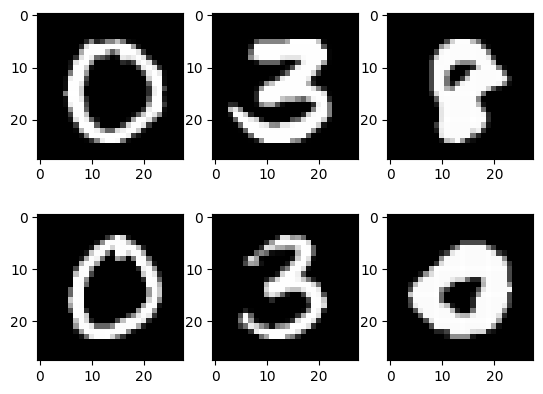

In [7]:
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(samples[i][0], cmap="gray")
img_grid = torchvision.utils.make_grid(samples)
writer.add_image("mnist_images", img_grid)
writer.flush()
plt.show()

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out


model = NeuralNet(input_size, hidden_size, num_classes)
model

NeuralNet(
  (l1): Linear(in_features=784, out_features=1000, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (l2): Linear(in_features=1000, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate
)  # Adam optimizer: https://arxiv.org/abs/1412.6980

writer.add_graph(model, samples.reshape(-1, 28 * 28))
writer.flush()

In [10]:
n_total_steps = len(train_loader)
running_loss = 0.0
running_corrects = 0



for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):

        # 100, 1, 28, 28 -> 100, 784

        # reshape images to (batch_size, input_size)

        images = images.reshape(-1, 28 * 28).to(device)

        labels = labels.to(device)


        # forward pass
        outputs = model(images)


        loss = criterion(outputs, labels)


        # backward pass

        optimizer.zero_grad()

        loss.backward()  # this does the backpropagation

        optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(torch.max(outputs, 1).indices == labels).item()

        if (i + 1) % 100 == 0:
            print(

                f"epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}"
            )
            writer.add_scalar(
                "training loss", running_loss / 100, epoch * n_total_steps + i
            )
            writer.add_scalar(
                "training accuracy", running_corrects / 100, epoch * n_total_steps + i
            )
            running_loss = 0.0
            running_corrects = 0
        writer.flush()

epoch 1/2, step 100/600, loss = 0.2666
epoch 1/2, step 200/600, loss = 0.2654
epoch 1/2, step 300/600, loss = 0.4130
epoch 1/2, step 400/600, loss = 0.0785
epoch 1/2, step 500/600, loss = 0.2470
epoch 1/2, step 600/600, loss = 0.1414
epoch 2/2, step 100/600, loss = 0.2522
epoch 2/2, step 200/600, loss = 0.1817
epoch 2/2, step 300/600, loss = 0.2419
epoch 2/2, step 400/600, loss = 0.0742
epoch 2/2, step 500/600, loss = 0.0241
epoch 2/2, step 600/600, loss = 0.0936


In [11]:
labels_array = []
preds = []

with torch.no_grad():

    n_correct = 0

    n_samples = 0

    for images, labels in test_loader:


        images = images.reshape(-1, 28 * 28).to(device)

        labels = labels.to(device)

        outputs = model(images)


        # max returns (value, index)

        _, predicted = torch.max(outputs, 1)


        n_samples += labels.shape[0]

        n_correct += (predicted == labels).sum().item()

        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        labels_array.append(labels)
    labels = torch.cat(
        labels_array
    )  # concatenates the labels in a one dimensional tensor
    preds = torch.cat(
        [torch.stack(batch) for batch in preds]
    )  # concatenates the predictions in a two dimensional tensor (batches times, 10)


    acc = 100.0 * n_correct / n_samples

    print(f"accuracy = {acc}")

    classes = range(10)
    for i in classes:
        labels_i = labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.flush()

accuracy = 96.46
